In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [6]:
#constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS   = 3
FILE_PATH  = "tomato_images"

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=FILE_PATH,
            shuffle=True,
            image_size=(IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE,
)


Found 14240 files belonging to 9 classes.


In [8]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[5 8 6 8 6 6 6 4 2 7 6 6 6 5 5 6 0 1 6 5 2 4 5 4 5 1 0 8 5 8 8 3]


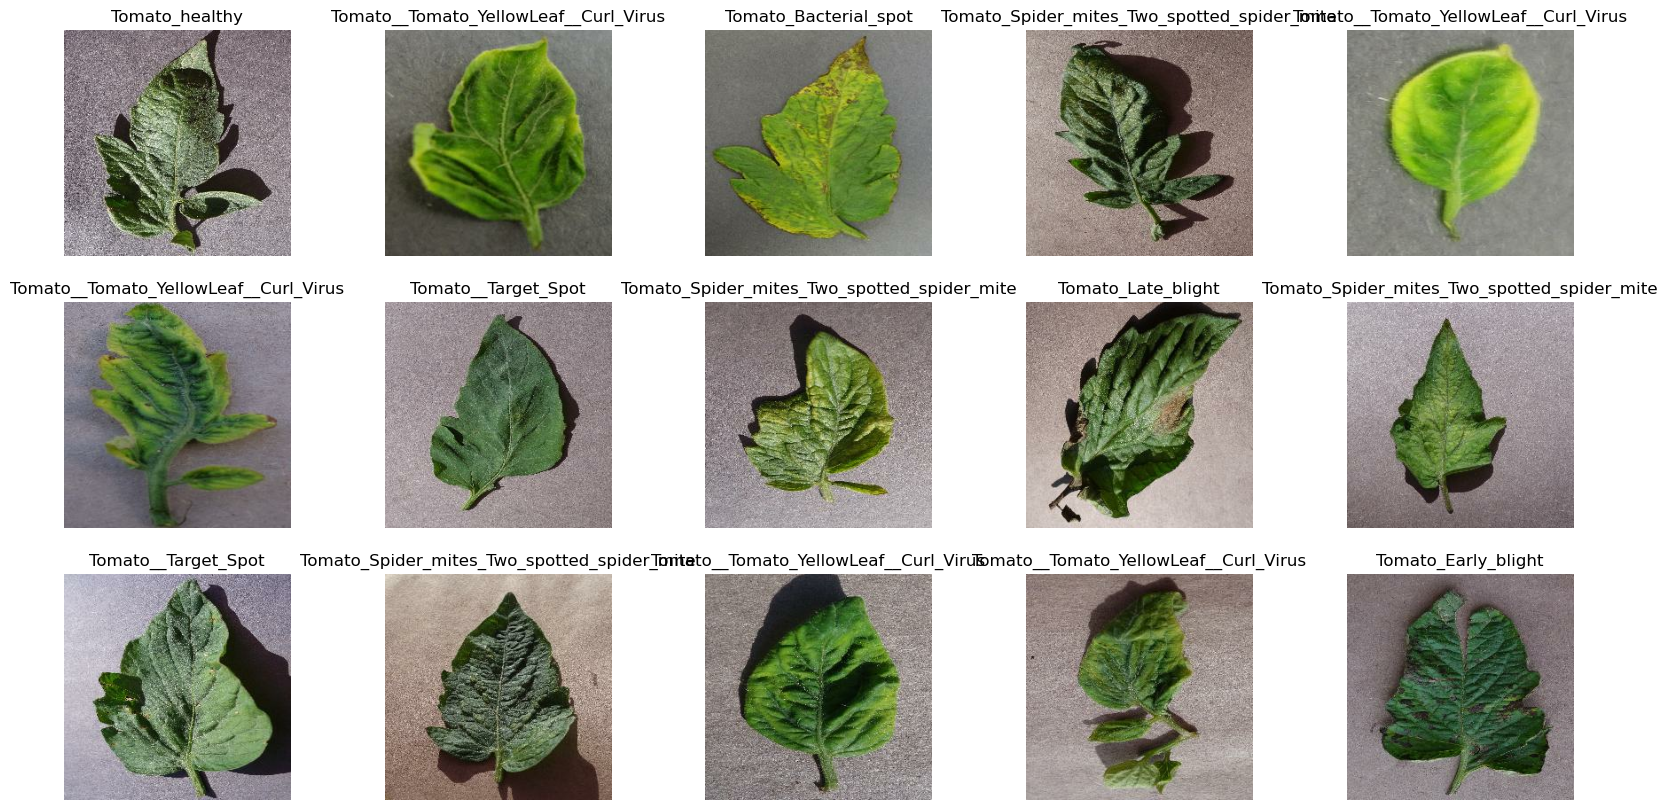

In [10]:
plt.figure(figsize=(20,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [11]:
def get_dataset_partitions(ds,train_split=0.8,test_split=0.1,valid_split=0.1,shuffle=True,shuffle_size=10000):
    assert  train_split+test_split+valid_split==1
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
    train_size = int(len(ds)*train_split)
    valid_size = int(len(ds)*valid_split)

  
    train_ds = ds.take(train_size)    
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)
    
    return train_ds ,test_ds, valid_ds

In [12]:
train_ds ,test_ds, valid_ds = get_dataset_partitions(dataset)

In [13]:
print(len(train_ds))
print(len(test_ds))
print(len(valid_ds))

356
45
44


In [14]:
rescale_and_resize=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,# will resize to the IMAGE_SIZE if there's any issue
    layers.experimental.preprocessing.Rescaling(1./255)  # Normalization
])

In [15]:
#data augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)


tomato_model = models.Sequential([
    rescale_and_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

tomato_model.build(input_shape=input_shape)

In [23]:
tomato_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [24]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [28]:
EPOCHS = 2

In [29]:
if 'history' not in locals():
    history = []
#model training
history.append(
    model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=valid_ds,
        verbose=1,
        epochs=EPOCHS
    )
)

Epoch 1/2
356/356 [==============================] - 645s 2s/step - loss: 1.3596 - accuracy: 0.5118 - val_loss: 1.6506 - val_accuracy: 0.5014
Epoch 2/2
356/356 [==============================] - 449s 1s/step - loss: 0.8567 - accuracy: 0.6955 - val_loss: 1.1097 - val_accuracy: 0.6129


In [30]:
scores = model.evaluate(test_ds)
scores

45/45 [==============================] - 22s 377ms/step - loss: 1.0987 - accuracy: 0.6104


[1.0987344980239868, 0.6104166507720947]

In [31]:
acc = []
val_acc = []
loss = []
val_loss = []

for h in history:
    acc.extend(h.history['accuracy'])
    val_acc.extend(h.history['val_accuracy'])
    loss.extend(h.history['loss'])
    val_loss.extend(h.history['val_loss'])

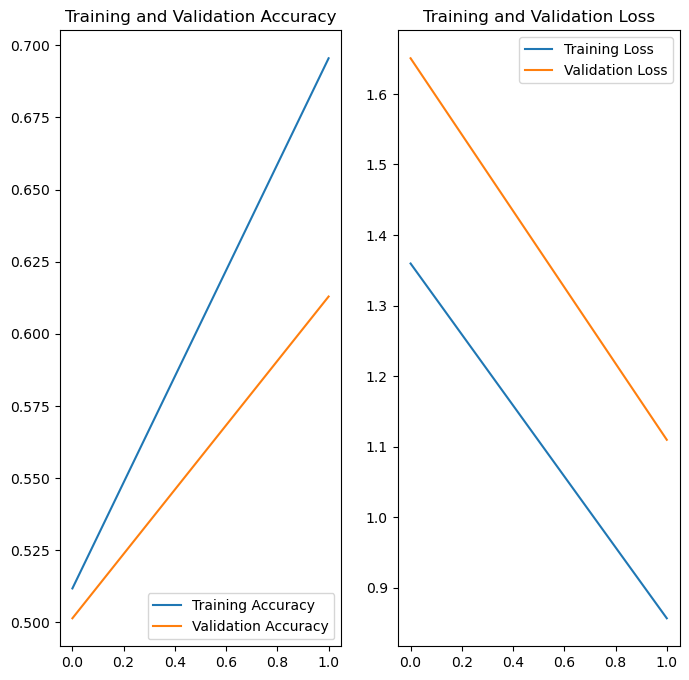

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_Late_blight
1/1 [==============================] - 0s 374ms/step
predicted label: Tomato_Late_blight


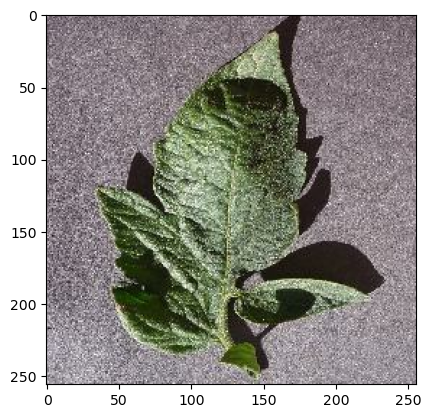

In [38]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
   
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    break